# MATRIXS REQUIRED TO DISPLAY

1. Each and every model with hyperparameter tuning (learning rate).

2. Validation loss curve, Training loss curve, Validation accuracy curve

3. Model training performance matrices (precision, recall, and F1 score)

4. Model testing performance matrices (precision, recall, and F1 score)

5. Number of epochs model trained on.

6. Dataset Before and After Augmentation.

7. Testing Confusion matrix.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import zipfile

import torch.nn.functional as F
from rich.console import Console
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn
from rich.table import Table

import pandas as pd
from torch.cuda.amp import autocast, GradScaler


from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
# Install Git in case it's not available in your environment
!apt-get install git

# Clone the repository from GitHub
!git clone https://github.com/Samin1362/MerakiNexus-V2.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.14).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Cloning into 'MerakiNexus-V2'...
remote: Enumerating objects: 6476, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 6476 (delta 12), reused 19 (delta 7), pack-reused 6441 (from 1)
Receiving objects: 100% (6476/6476), 1.84 GiB | 36.98 MiB/s, done.
Resolving deltas: 100% (135/135), done.
Updating files: 100% (6231/6231), done.


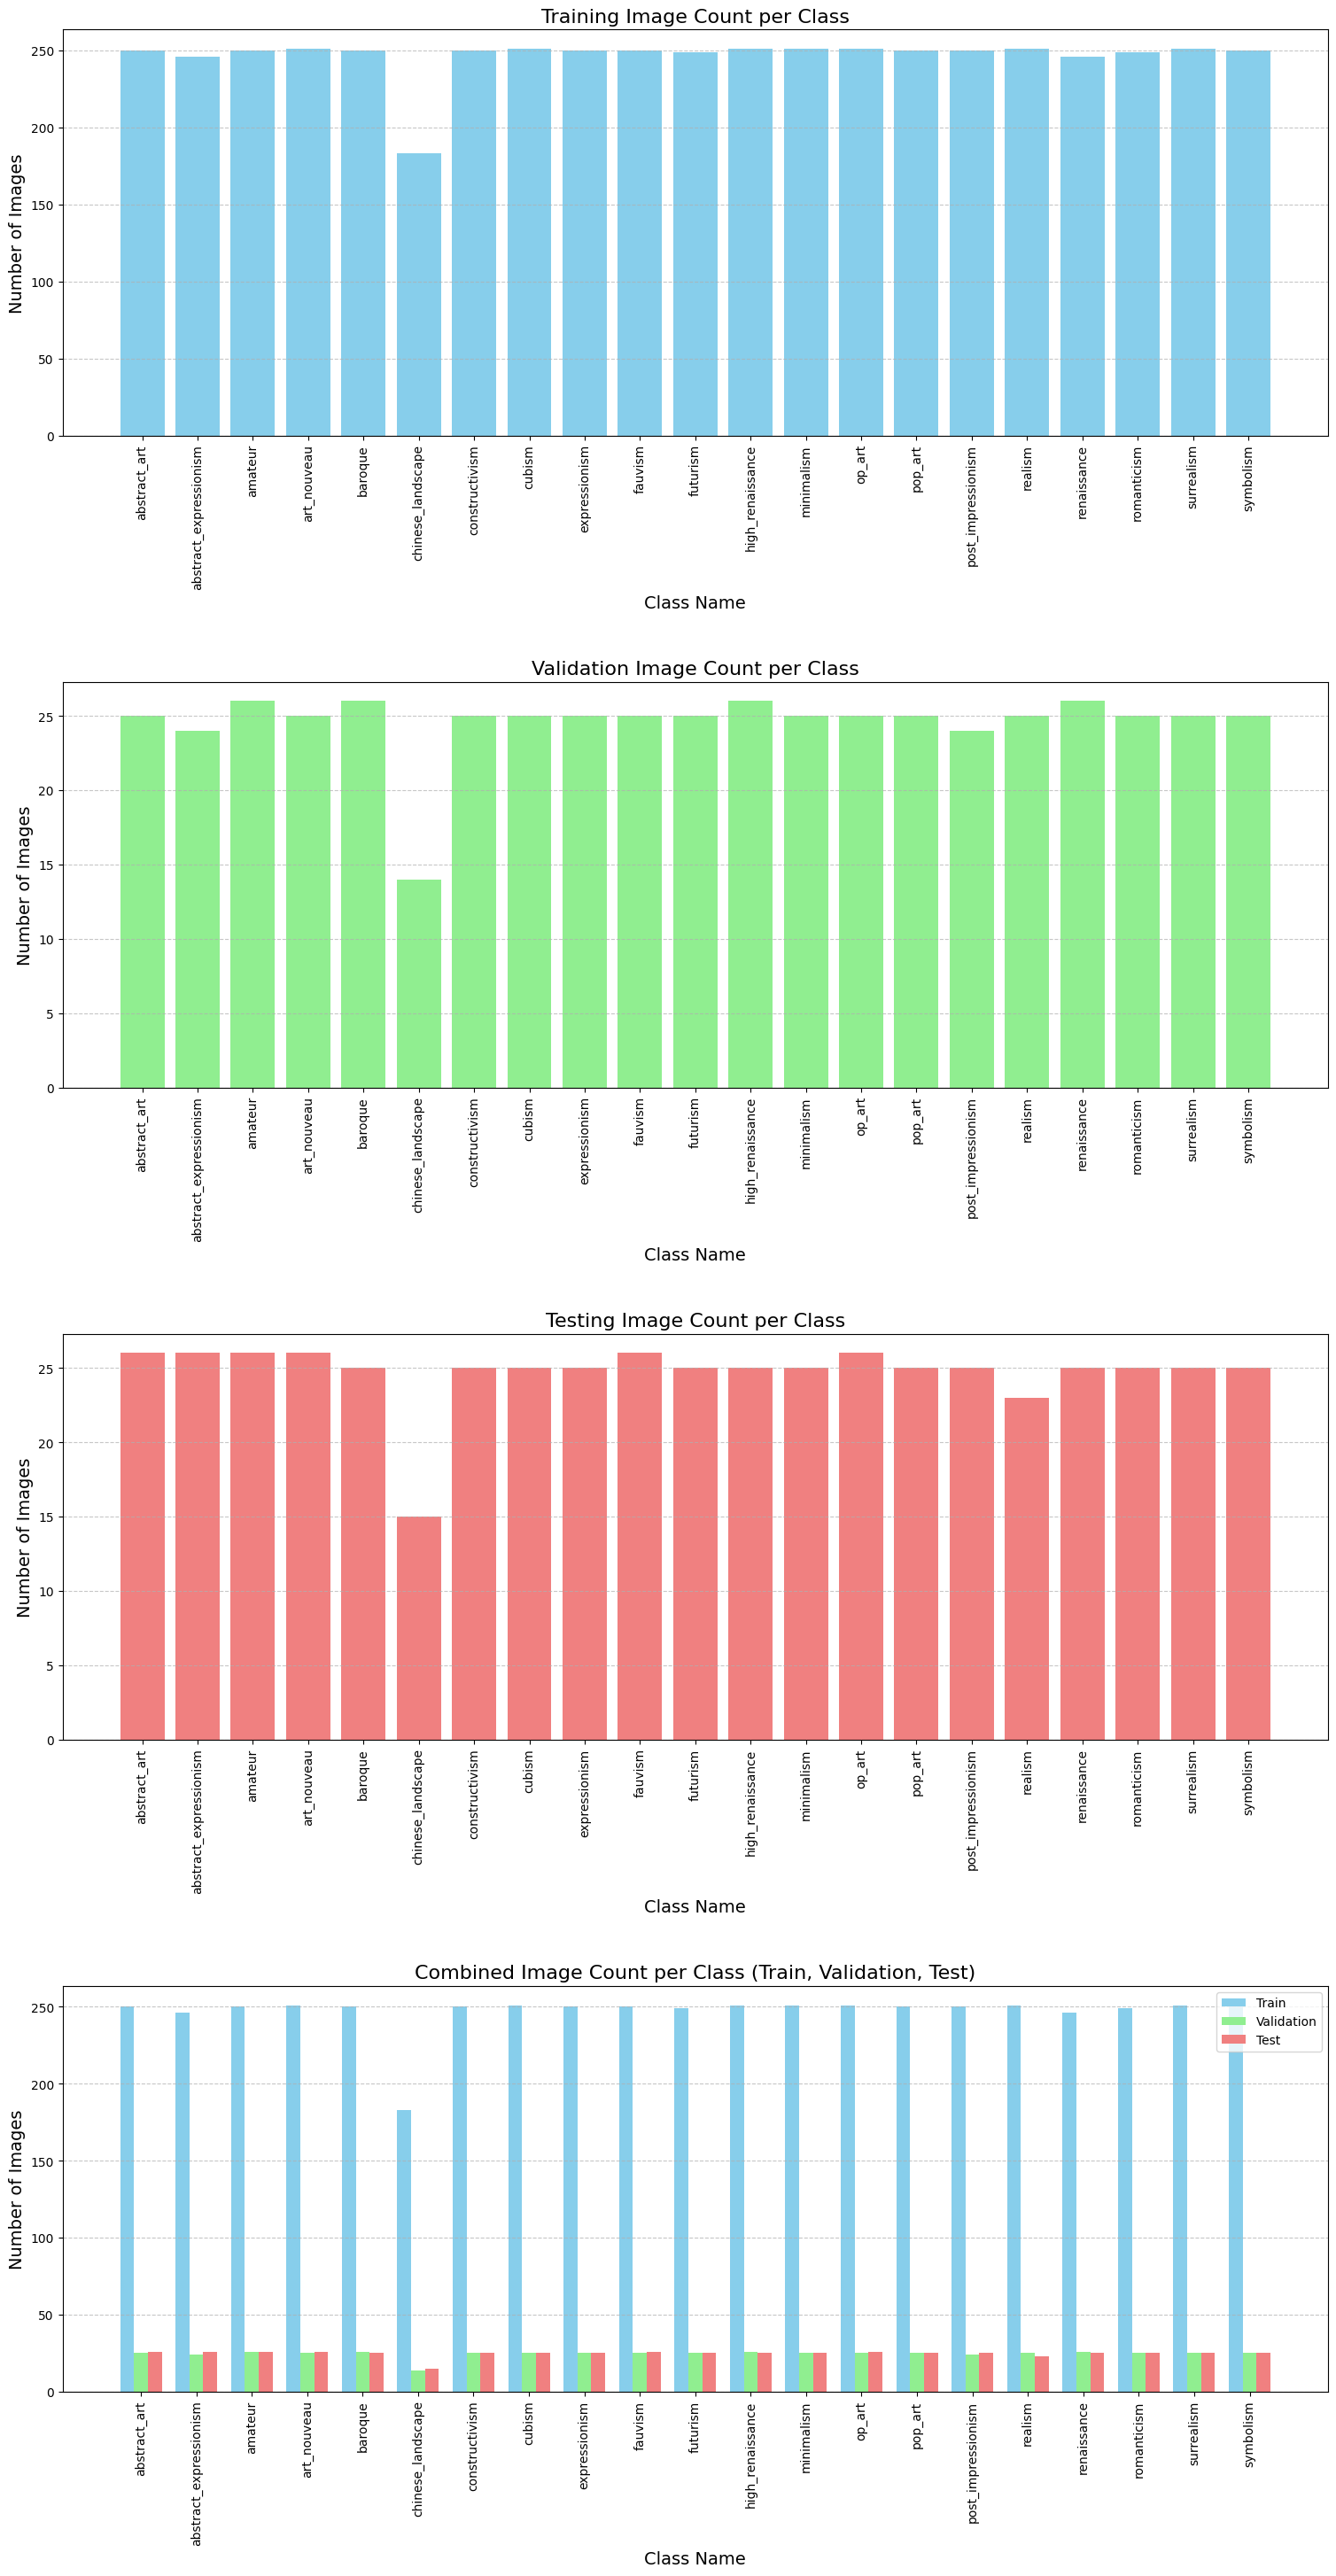

In [3]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets

# Define dataset path
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"  # Update path if needed

# Load datasets
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train")
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val")
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test")

# Get class names and initialize counters
class_names = train_dataset.classes
train_image_counts, val_image_counts, test_image_counts = [], [], []

# Count images per class
for class_name in class_names:
    train_count = len(os.listdir(os.path.join(train_dataset.root, class_name)))
    val_count = len(os.listdir(os.path.join(val_dataset.root, class_name)))
    test_count = len(os.listdir(os.path.join(test_dataset.root, class_name)))

    train_image_counts.append(train_count)
    val_image_counts.append(val_count)
    test_image_counts.append(test_count)

# Create vertically stacked subplots
fig, axes = plt.subplots(4, 1, figsize=(16, 30))  # Wider + taller for readability

# Common x-axis style
def style_x_axis(ax):
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=90, fontsize=10)
    ax.set_xlabel("Class Name", fontsize=14)
    ax.set_ylabel("Number of Images", fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Training set plot
axes[0].bar(range(len(class_names)), train_image_counts, color='skyblue')
axes[0].set_title('Training Image Count per Class', fontsize=16)
style_x_axis(axes[0])

# Validation set plot
axes[1].bar(range(len(class_names)), val_image_counts, color='lightgreen')
axes[1].set_title('Validation Image Count per Class', fontsize=16)
style_x_axis(axes[1])

# Test set plot
axes[2].bar(range(len(class_names)), test_image_counts, color='lightcoral')
axes[2].set_title('Testing Image Count per Class', fontsize=16)
style_x_axis(axes[2])

# Combined view with grouped bars
bar_width = 0.25
x = list(range(len(class_names)))

axes[3].bar([i - bar_width for i in x], train_image_counts, width=bar_width, label='Train', color='skyblue')
axes[3].bar(x, val_image_counts, width=bar_width, label='Validation', color='lightgreen')
axes[3].bar([i + bar_width for i in x], test_image_counts, width=bar_width, label='Test', color='lightcoral')

axes[3].set_title('Combined Image Count per Class (Train, Validation, Test)', fontsize=16)
axes[3].set_xticks(x)
axes[3].set_xticklabels(class_names, rotation=90, fontsize=10)
axes[3].set_xlabel("Class Name", fontsize=14)
axes[3].set_ylabel("Number of Images", fontsize=14)
axes[3].legend()
axes[3].grid(axis='y', linestyle='--', alpha=0.7)

# Final layout adjustments
plt.tight_layout(pad=4)
plt.show()


| Hyperparameter       | Value     | Reason                                                              |
| -------------------- | --------- | ------------------------------------------------------------------- |
| `lr` (learning rate) | `1e-4`    | Lower value to fine-tune pretrained ResNet layers                   |
| `weight_decay`       | `1e-5`    | Helps reduce overfitting                                            |
| `dropout`            | `0.3–0.5` | Regularization to prevent overfitting during fully connected layers |
| `batch_size`         | `32`      | Balanced between memory usage and performance                       |
| `optimizer`          | `Adam`    | Well-suited for transfer learning                                   |
| `num_epochs`         | `25`      | Enough to converge for mid-sized dataset                            |


Train samples: 5168 | Val samples: 512 | Test samples: 511


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Starting Training...



Epoch 1/25 Training: 100%|██████████| 162/162 [01:17<00:00,  2.10it/s, loss=1.88]


Epoch 1 Completed | Train Loss: 2.2123 | Val Loss: 1.6246 | Val Acc: 49.02% | Time: 83.31s


Epoch 2/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.11it/s, loss=1.09]


Epoch 2 Completed | Train Loss: 1.3159 | Val Loss: 1.4422 | Val Acc: 58.01% | Time: 83.64s


Epoch 3/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.11it/s, loss=1.39]


Epoch 3 Completed | Train Loss: 0.9246 | Val Loss: 1.4709 | Val Acc: 58.01% | Time: 83.50s


Epoch 4/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.12it/s, loss=0.586]


Epoch 4 Completed | Train Loss: 0.6858 | Val Loss: 1.2652 | Val Acc: 59.77% | Time: 82.81s


Epoch 5/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.11it/s, loss=0.517]


Epoch 5 Completed | Train Loss: 0.4975 | Val Loss: 1.4814 | Val Acc: 61.72% | Time: 82.74s


Epoch 6/25 Training: 100%|██████████| 162/162 [01:17<00:00,  2.10it/s, loss=0.235]


Epoch 6 Completed | Train Loss: 0.3861 | Val Loss: 1.5398 | Val Acc: 58.59% | Time: 83.51s


Epoch 7/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.12it/s, loss=0.372]


Epoch 7 Completed | Train Loss: 0.3060 | Val Loss: 1.4914 | Val Acc: 61.13% | Time: 83.03s


Epoch 8/25 Training: 100%|██████████| 162/162 [01:15<00:00,  2.13it/s, loss=0.285]


Epoch 8 Completed | Train Loss: 0.2483 | Val Loss: 1.4474 | Val Acc: 63.67% | Time: 82.36s


Epoch 9/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.11it/s, loss=0.589]


Epoch 9 Completed | Train Loss: 0.2119 | Val Loss: 1.4644 | Val Acc: 60.35% | Time: 82.73s


Epoch 10/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.11it/s, loss=0.0367]


Epoch 10 Completed | Train Loss: 0.1767 | Val Loss: 1.5297 | Val Acc: 62.50% | Time: 83.22s


Epoch 11/25 Training: 100%|██████████| 162/162 [01:19<00:00,  2.05it/s, loss=0.219]


Epoch 11 Completed | Train Loss: 0.1506 | Val Loss: 1.5712 | Val Acc: 63.67% | Time: 85.67s


Epoch 12/25 Training: 100%|██████████| 162/162 [01:17<00:00,  2.10it/s, loss=0.216]


Epoch 12 Completed | Train Loss: 0.1522 | Val Loss: 1.7164 | Val Acc: 60.55% | Time: 83.91s


Epoch 13/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.12it/s, loss=0.204]


Epoch 13 Completed | Train Loss: 0.1442 | Val Loss: 1.6875 | Val Acc: 63.28% | Time: 83.18s


Epoch 14/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.12it/s, loss=0.436]


Epoch 14 Completed | Train Loss: 0.1288 | Val Loss: 1.5721 | Val Acc: 61.72% | Time: 82.72s


Epoch 15/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.11it/s, loss=0.322]


Epoch 15 Completed | Train Loss: 0.1130 | Val Loss: 1.8525 | Val Acc: 59.38% | Time: 82.72s


Epoch 16/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.13it/s, loss=0.337]


Epoch 16 Completed | Train Loss: 0.1115 | Val Loss: 1.6814 | Val Acc: 63.87% | Time: 82.84s


Epoch 17/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.13it/s, loss=0.0818]


Epoch 17 Completed | Train Loss: 0.1031 | Val Loss: 1.6247 | Val Acc: 61.33% | Time: 82.90s


Epoch 18/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.12it/s, loss=0.125]


Epoch 18 Completed | Train Loss: 0.1105 | Val Loss: 1.6749 | Val Acc: 64.84% | Time: 82.62s


Epoch 19/25 Training: 100%|██████████| 162/162 [01:17<00:00,  2.10it/s, loss=0.179]


Epoch 19 Completed | Train Loss: 0.1062 | Val Loss: 1.8696 | Val Acc: 61.52% | Time: 83.18s


Epoch 20/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.12it/s, loss=0.153]


Epoch 20 Completed | Train Loss: 0.0952 | Val Loss: 1.6794 | Val Acc: 63.09% | Time: 82.90s


Epoch 21/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.13it/s, loss=0.293]


Epoch 21 Completed | Train Loss: 0.0954 | Val Loss: 1.8606 | Val Acc: 61.72% | Time: 82.91s


Epoch 22/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.12it/s, loss=0.00743]


Epoch 22 Completed | Train Loss: 0.1025 | Val Loss: 1.8270 | Val Acc: 60.55% | Time: 82.60s


Epoch 23/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.12it/s, loss=0.288]


Epoch 23 Completed | Train Loss: 0.0968 | Val Loss: 1.8756 | Val Acc: 60.16% | Time: 82.52s


Epoch 24/25 Training: 100%|██████████| 162/162 [01:16<00:00,  2.11it/s, loss=0.0473]


Epoch 24 Completed | Train Loss: 0.0956 | Val Loss: 1.9191 | Val Acc: 58.59% | Time: 83.29s


Epoch 25/25 Training: 100%|██████████| 162/162 [01:15<00:00,  2.14it/s, loss=0.272]


Epoch 25 Completed | Train Loss: 0.0811 | Val Loss: 1.7847 | Val Acc: 62.30% | Time: 82.83s

Total Training Time: 2077.64s (34.63 minutes)


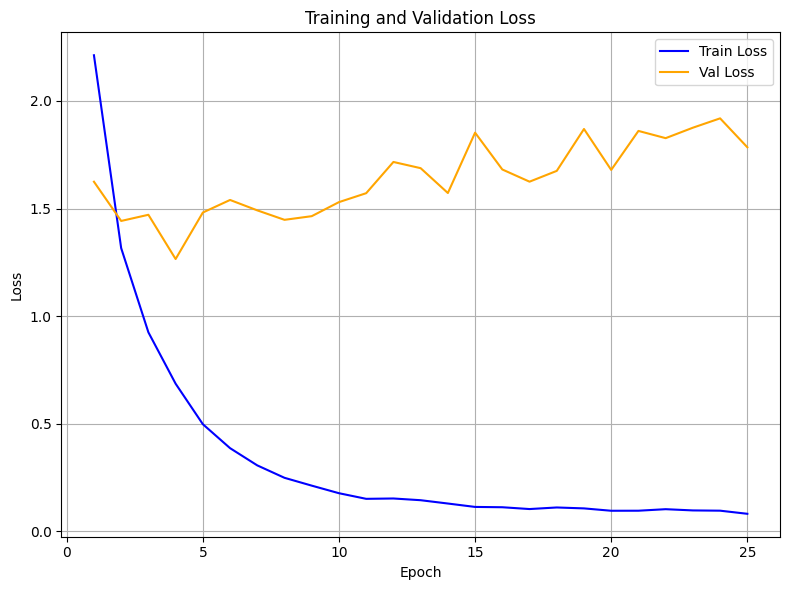

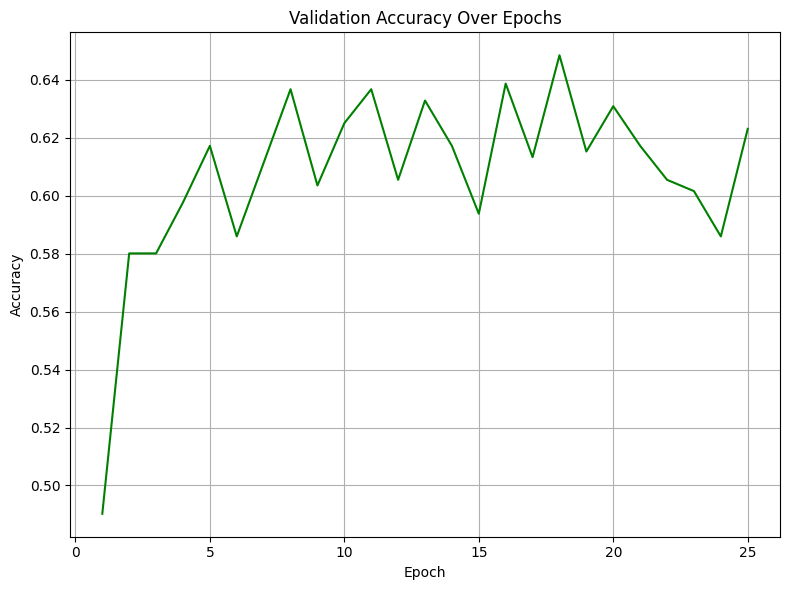

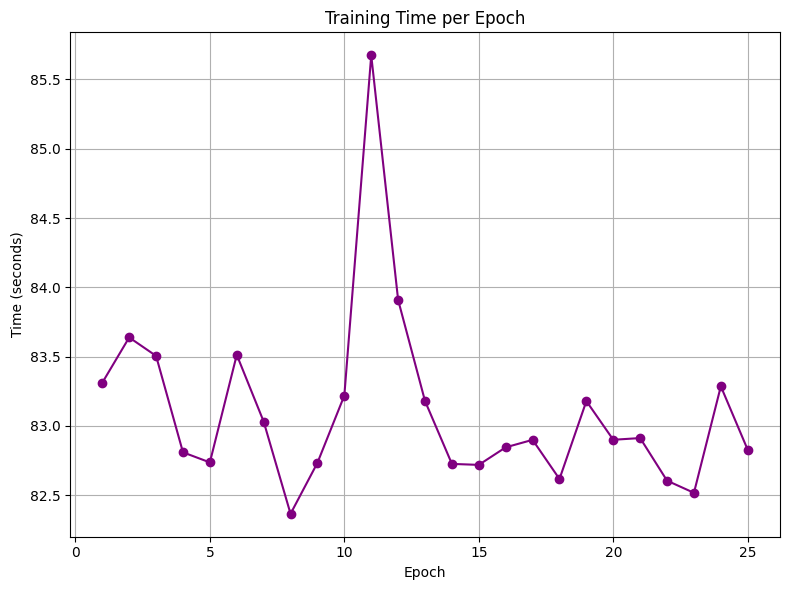


Test Accuracy: 63.01%

Precision, Recall, F1-Score Table:

                        precision  recall  f1-score
abstract_art                0.385   0.400     0.392
abstract_expressionism      0.667   0.480     0.558
amateur                     0.778   0.560     0.651
art_nouveau                 0.667   0.240     0.353
baroque                     0.704   0.792     0.745
chinese_landscape           0.667   1.000     0.800
constructivism              0.579   0.440     0.500
cubism                      0.750   0.600     0.667
expressionism               0.556   0.400     0.465
fauvism                     0.367   0.440     0.400
futurism                    0.571   0.800     0.667
high_renaissance            0.824   0.560     0.667
minimalism                  0.828   0.960     0.889
op_art                      0.700   0.840     0.764
pop_art                     0.643   0.720     0.679
post_impressionism          0.571   0.480     0.522
realism                     0.654   0.739     0.694
rena

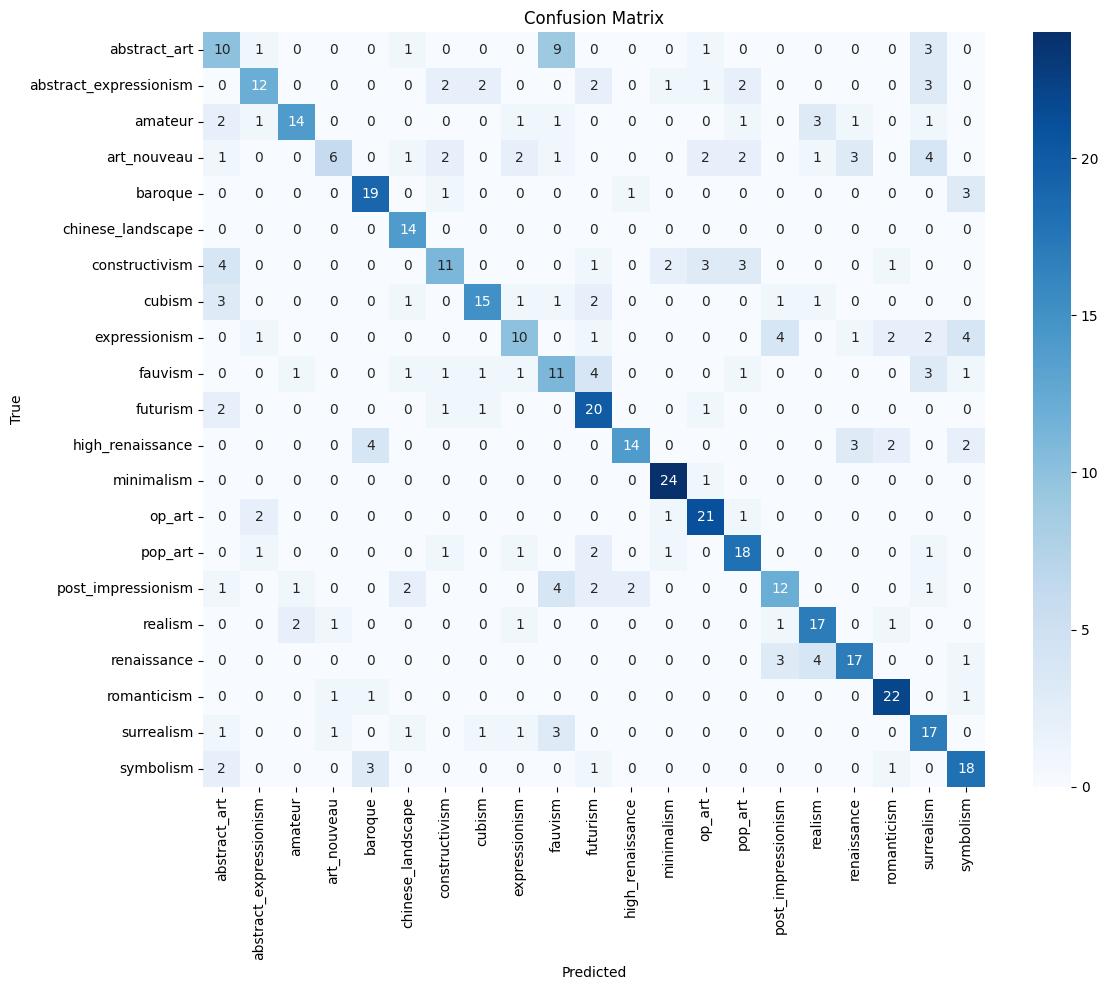

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import pandas as pd
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======== Data Augmentation and Normalization ========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ======== Dataset and Dataloaders ========
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"
train_data = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
val_data = datasets.ImageFolder(root=f"{dataset_path}/val", transform=transform)
test_data = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

print(f"Train samples: {len(train_data)} | Val samples: {len(val_data)} | Test samples: {len(test_data)}")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# ======== Model Definition (ResNet-50) ========
class ArtworkClassificationResNet(nn.Module):
    def __init__(self, num_classes=11):
        super(ArtworkClassificationResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        # Freeze all layers initially
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Unfreeze last block for fine-tuning
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True

        # Replace FC layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

model = ArtworkClassificationResNet(num_classes=len(train_data.classes)).to(device)

# ======== Loss Function and Optimizer ========
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)

# ======== Training Loop ========
num_epochs = 25
train_losses = []
val_losses = []
val_accuracies = []
epoch_times = []

print("\nStarting Training...\n")
for epoch in range(num_epochs):
    epoch_start = time.time()

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            tepoch.set_postfix(loss=loss.item())

    train_loss_epoch = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss_epoch)

    # ======== Validation ========
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss_epoch = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss_epoch)
    val_accuracies.append(val_accuracy)

    epoch_duration = time.time() - epoch_start
    epoch_times.append(epoch_duration)

    print(f"Epoch {epoch+1} Completed | Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss_epoch:.4f} | Val Acc: {val_accuracy*100:.2f}% | Time: {epoch_duration:.2f}s")

total_training_time = sum(epoch_times)
print(f"\nTotal Training Time: {total_training_time:.2f}s ({total_training_time/60:.2f} minutes)")

# ======== Loss Curve (Train vs Val) ========
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss", color='orange')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ======== Validation Accuracy Curve ========
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), val_accuracies, label="Val Accuracy", color='green')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# ======== Time Per Epoch Curve ========
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), epoch_times, marker='o', color='purple')
plt.title("Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ======== Evaluation on Test Set ========
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# ======== Classification Report & Confusion Matrix ========
report = classification_report(all_labels, all_preds, target_names=train_data.classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()

print("\nPrecision, Recall, F1-Score Table:\n")
print(df_report[['precision', 'recall', 'f1-score']].round(3))

# ======== Confusion Matrix ========
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [7]:
scripted_model = torch.jit.script(model)  # Convert to TorchScript

# Save the TorchScript model to a file
torch.jit.save(scripted_model, "/content/artwork_classification_model_subject_2_resNet_50.pth");


✅ Test Accuracy: 64.58%

📊 Classification Report (per class):

                        precision  recall  f1-score
abstract_art                0.391   0.360     0.375
abstract_expressionism      0.667   0.640     0.653
amateur                     0.882   0.600     0.714
art_nouveau                 0.800   0.160     0.267
baroque                     0.760   0.792     0.776
chinese_landscape           0.778   1.000     0.875
constructivism              0.591   0.520     0.553
cubism                      0.889   0.640     0.744
expressionism               0.632   0.480     0.545
fauvism                     0.486   0.680     0.567
futurism                    0.486   0.680     0.567
high_renaissance            0.875   0.560     0.683
minimalism                  0.821   0.920     0.868
op_art                      0.676   0.920     0.780
pop_art                     0.682   0.600     0.638
post_impressionism          0.600   0.480     0.533
realism                     0.679   0.826     0.745


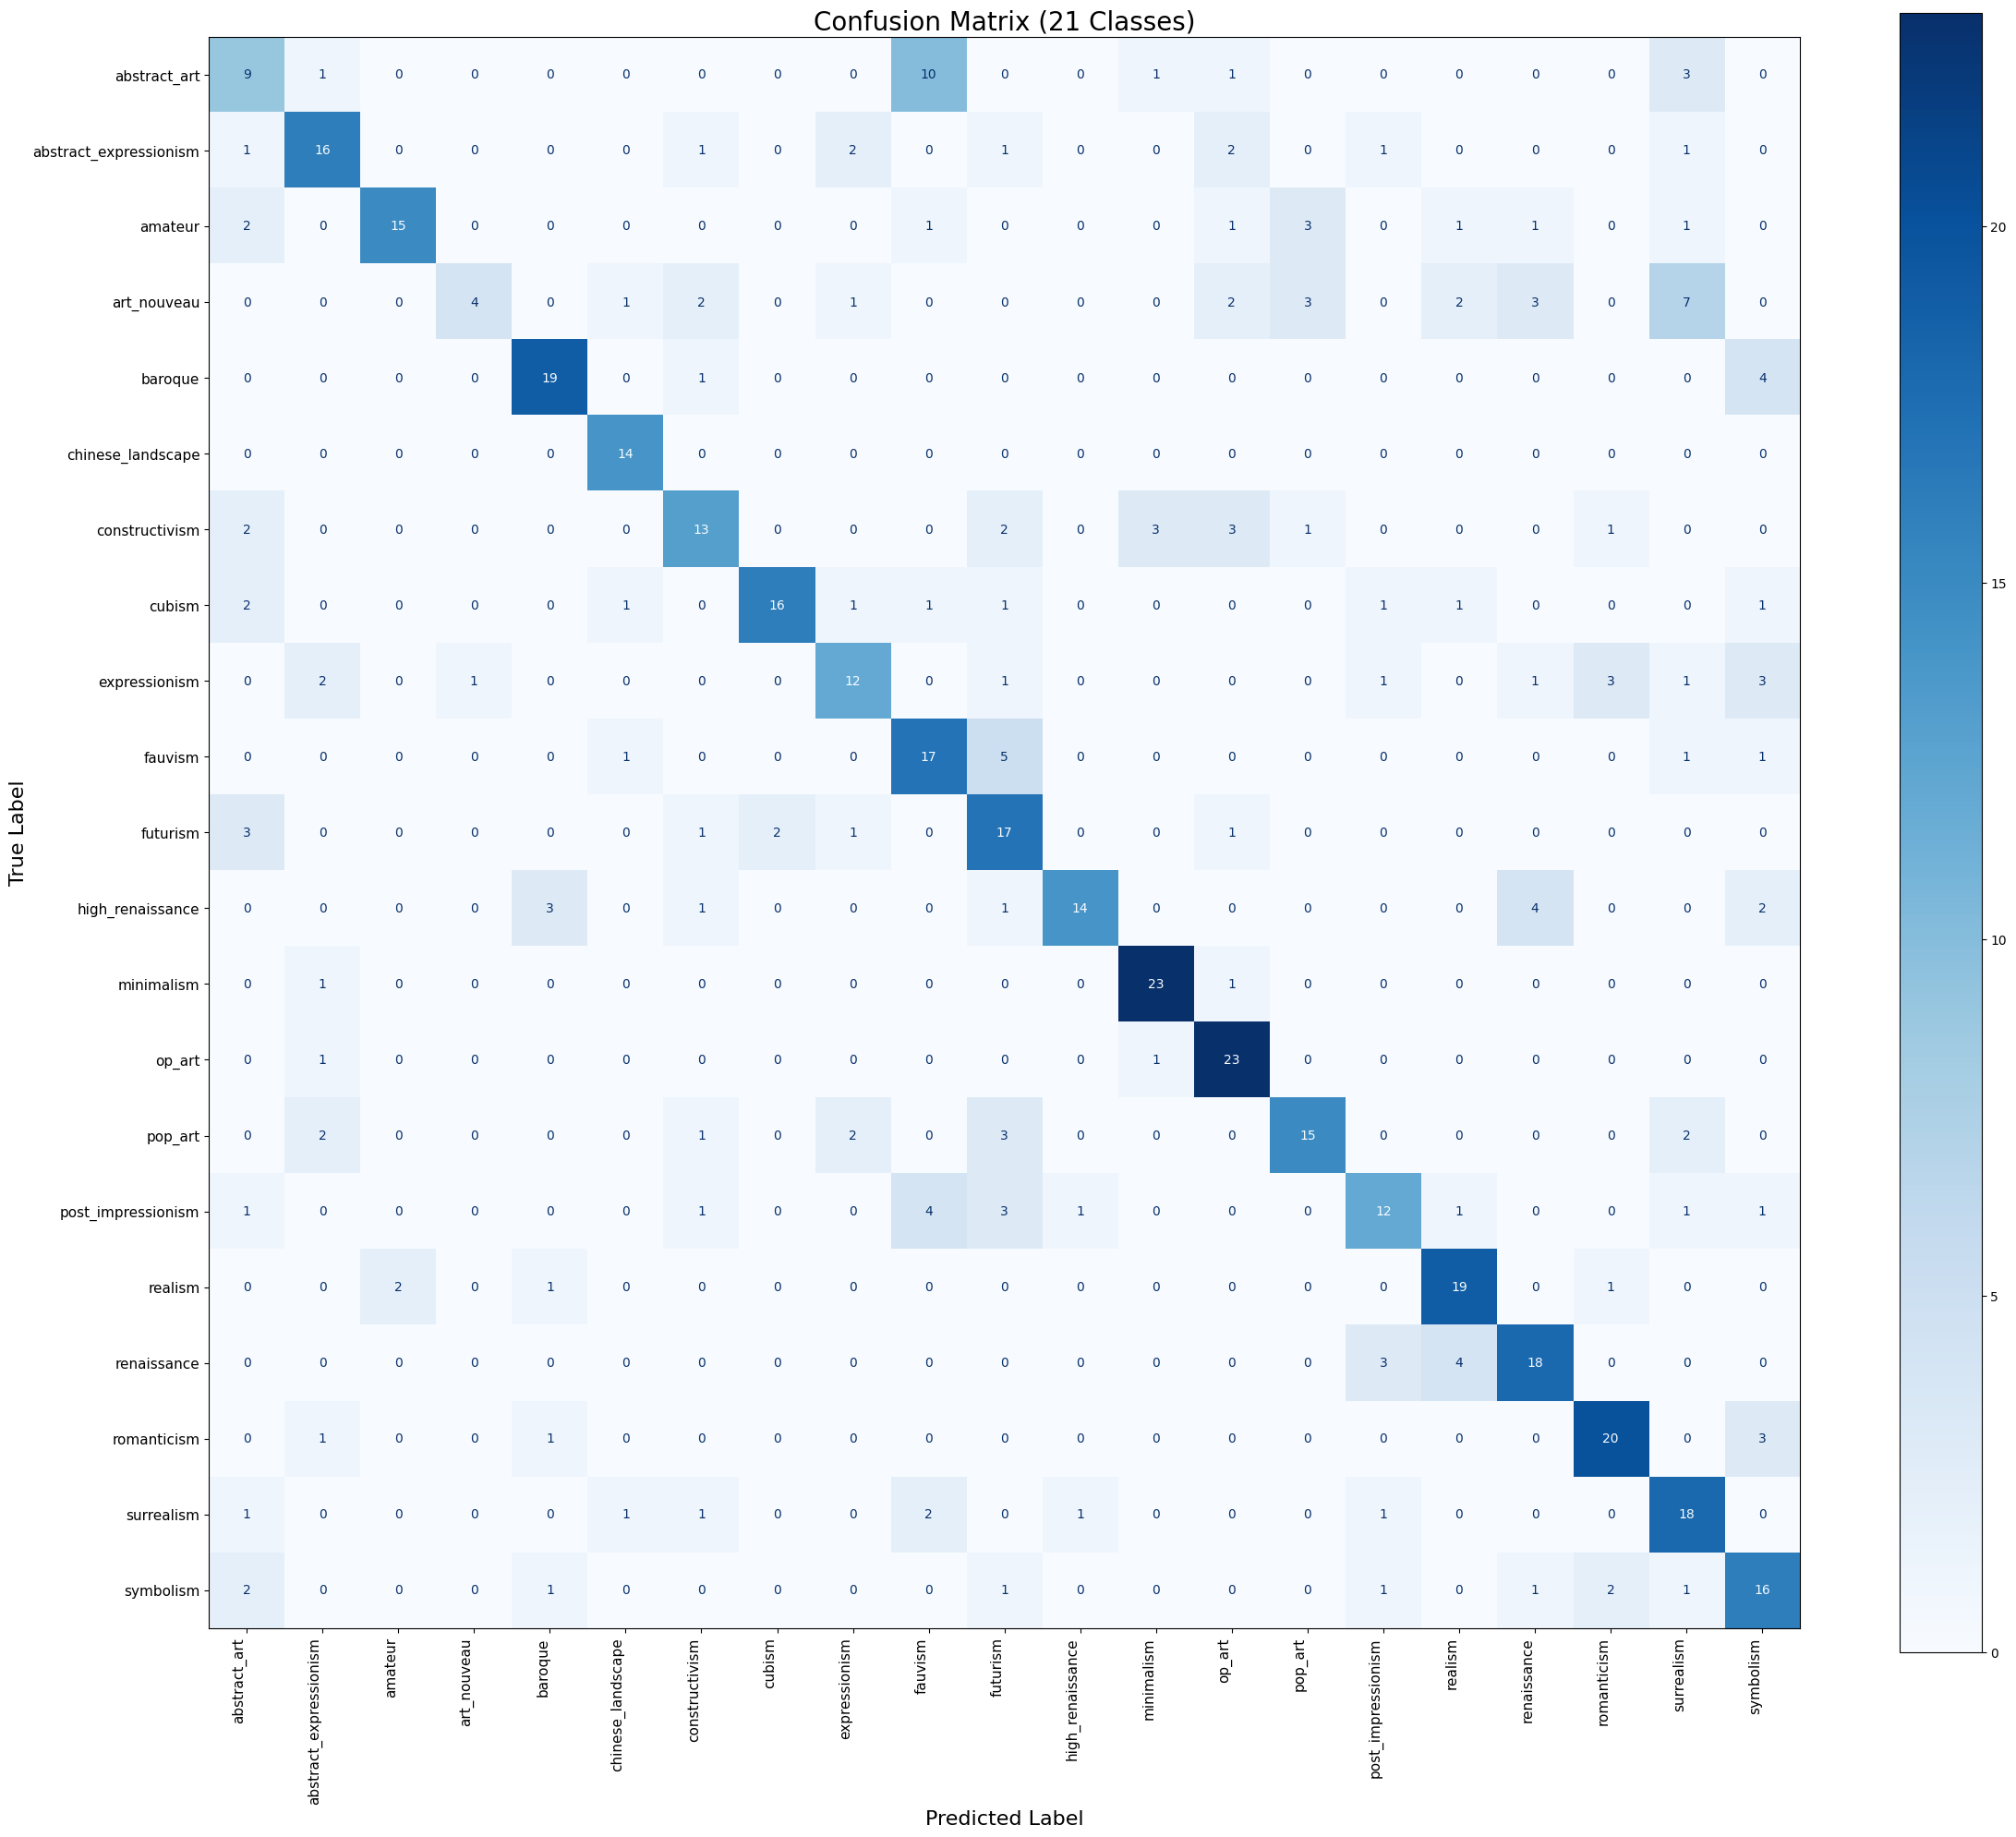

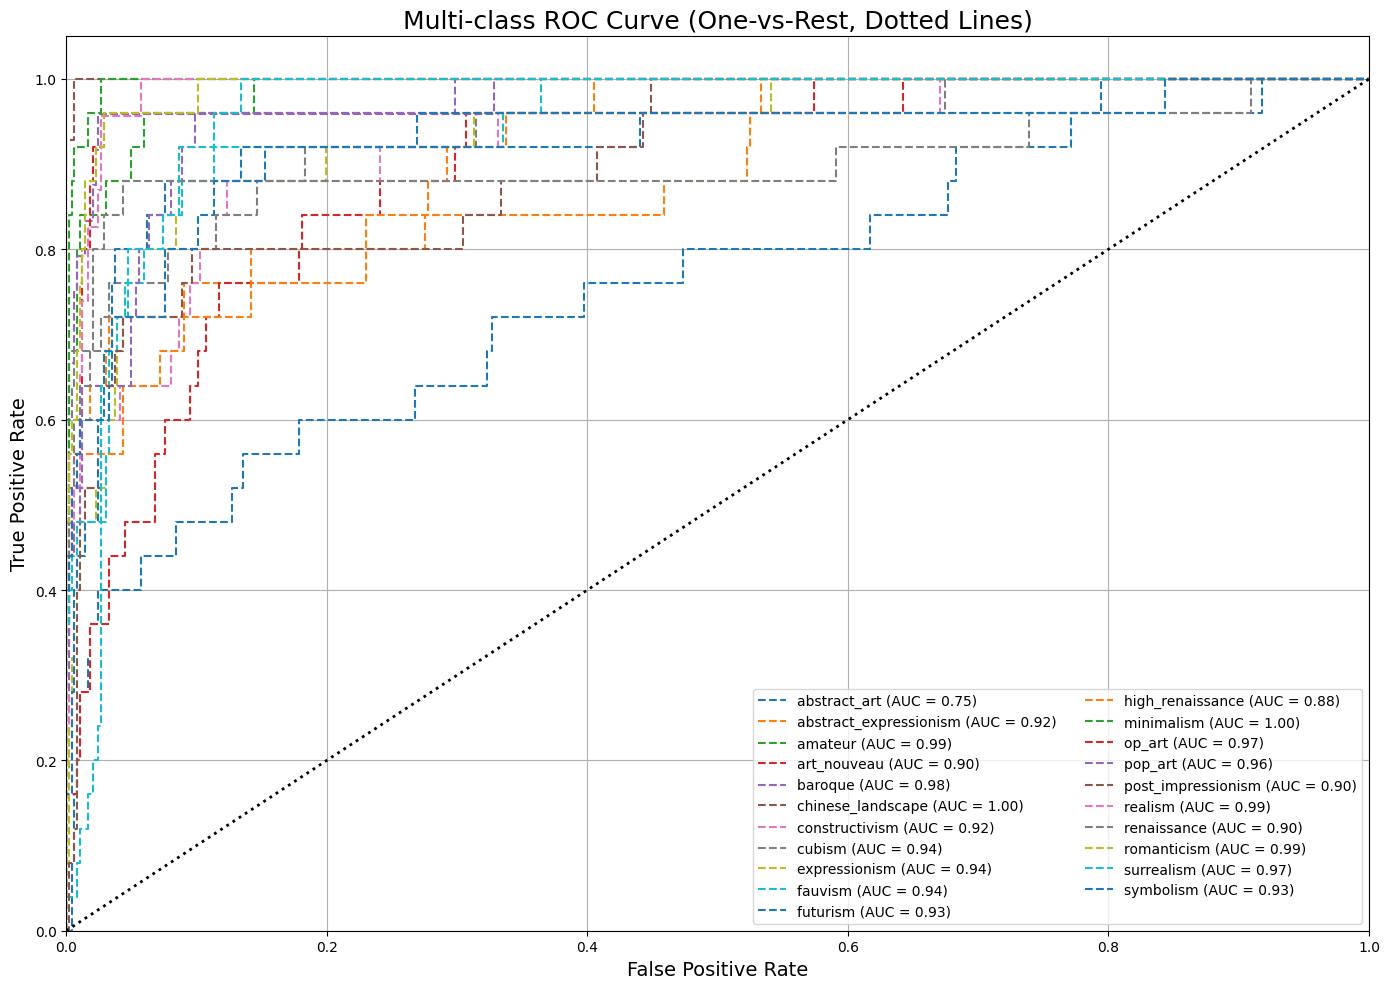

In [8]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

# ========== Define transforms ==========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ========== Load the test dataset ==========
test_dataset = datasets.ImageFolder(
    '/content/MerakiNexus-V2/art_classification_model/dataset/test',
    transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = test_dataset.classes
num_classes = len(class_names)

# ========== Load TorchScript model ==========
scripted_model = torch.jit.load("/content/artwork_classification_model_subject_2_resNet_50.pth")
scripted_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scripted_model.to(device)

# ========== Evaluation on Test Set ==========
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = scripted_model(images)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# ========== Overall Test Accuracy ==========
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")

# ========== Precision, Recall, F1-Score ==========
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    digits=3,
    output_dict=True
)
df_metrics = pd.DataFrame(report).transpose()
print("\n📊 Classification Report (per class):\n")
print(df_metrics[['precision', 'recall', 'f1-score']].round(3))

# Optional: Save report as CSV
# df_metrics.to_csv("classification_metrics_test.csv")

# ========== Confusion Matrix ==========
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(24, 20))
disp.plot(
    cmap="Blues",
    values_format='d',
    ax=ax
)

plt.setp(ax.get_xticklabels(), rotation=90, ha='right', fontsize=11)
plt.setp(ax.get_yticklabels(), fontsize=11)
ax.set_title("Confusion Matrix (21 Classes)", fontsize=20)
ax.set_xlabel("Predicted Label", fontsize=16)
ax.set_ylabel("True Label", fontsize=16)
plt.tight_layout()
plt.show()

# ========== ROC Curve ==========
# Binarize labels
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
y_score = np.array(all_probs)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class as dotted lines
plt.figure(figsize=(14, 10))
for i in range(num_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        linestyle='--',
        lw=1.5,
        label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})"
    )

plt.plot([0, 1], [0, 1], 'k:', lw=2)  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Multi-class ROC Curve (One-vs-Rest, Dotted Lines)", fontsize=18)
plt.legend(loc="lower right", fontsize=10, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


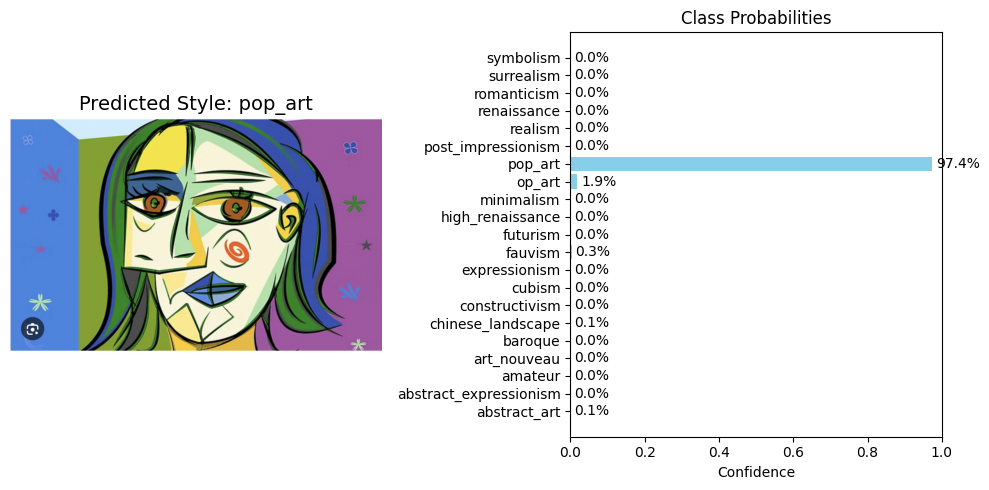

In [10]:
scripted_model = torch.jit.load("/content/artwork_classification_model_subject_2_resNet_50.pth")
scripted_model.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom dataset
class CustomArtworkDataset(datasets.ImageFolder):
    def __getitem__(self, idx):
        path, class_idx = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, class_idx

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet prefers 224x224 input for b0
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset paths
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"
train_data = CustomArtworkDataset(root=f"{dataset_path}/train", transform=transform)
val_data = CustomArtworkDataset(root=f"{dataset_path}/val", transform=transform)
test_data = CustomArtworkDataset(root=f"{dataset_path}/test", transform=transform)

# --- Visualize prediction for a single image ---
def predict_single_image(image_path, model, transform, class_names):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Set model to evaluation mode and make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class_idx = output.argmax(dim=1).item()
        predicted_class = class_names[predicted_class_idx]
        probabilities = torch.nn.functional.softmax(output, dim=1).cpu().numpy()[0]

    # Visualization
    plt.figure(figsize=(10, 5))

    # Show the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Predicted Style: {predicted_class}", fontsize=14)
    plt.axis("off")

    # Show prediction confidence for each class
    plt.subplot(1, 2, 2)
    bars = plt.barh(class_names, probabilities, color='skyblue')
    plt.xlabel("Confidence")
    plt.title("Class Probabilities")
    plt.xlim([0, 1])
    for bar in bars:
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                 f"{bar.get_width()*100:.1f}%", va='center')
    plt.tight_layout()
    plt.show()

# Example usage
test_image_path = "2.png"  # change this to your test image
predict_single_image(test_image_path, scripted_model, transform, train_data.classes)
